/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Starting FAST Model Training + SHAP...
Loading data...
Preprocessing...
Training Random Forest (Speed Mode)...

🏆 Final Model AUC Score: 0.9503
Extracting Top Features...
Generating SHAP Plot...
Exporting Dashboard Data...

🎉 DONE! Total Time: 0.4 minutes


<Figure size 640x480 with 0 Axes>

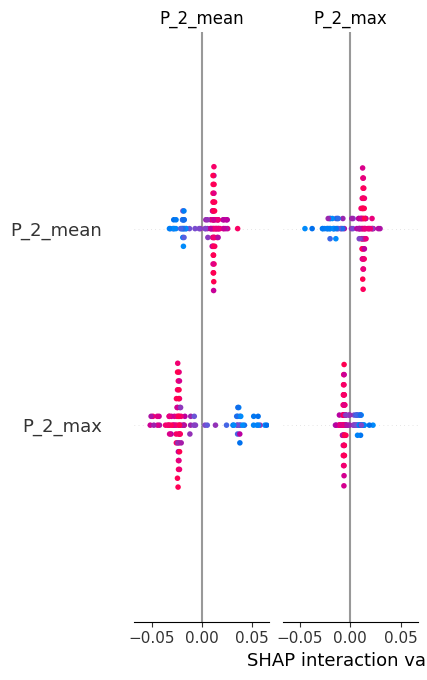

In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import time

def train_fast_model():
    start_time = time.time()
    print("🚀 Starting FAST Model Training + SHAP...")
    
    # 1. Load Data
    print("Loading data...")
    df = pd.read_csv('customer_features_enhanced.csv')
    
    # 2. Optimization: Downcast datatypes to save memory
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')
    
    # 3. Preprocessing
    print("Preprocessing...")
    X = df.drop(columns=['customer_ID', 'target'])
    y = df['target']
    ids = df['customer_ID']
    
    # Simple Categorical Encoding
    cat_cols = X.select_dtypes(include=['object']).columns
    for col in cat_cols:
        X[col] = X[col].fillna("Missing")
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        
    # Fast Imputation (Fill NaNs with 0 for speed - acceptable for Trees)
    X = X.fillna(0)

    # 4. Split
    X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
        X, y, ids, test_size=0.2, random_state=42
    )
    
    # 5. FAST Training
    print("Training Random Forest (Speed Mode)...")
    # max_samples=0.2 means each tree only looks at 20% of data (huge speedup)
    model = RandomForestClassifier(
        n_estimators=20, 
        max_depth=12, 
        max_samples=0.2, 
        random_state=42, 
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # 6. Evaluate
    probs = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    print(f"\n🏆 Final Model AUC Score: {auc:.4f}")
    
    # 7. Feature Importance
    print("Extracting Top Features...")
    feature_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(20)
    feature_imp.to_csv('top_20_features.csv', index=False)
    
    # 8. SHAP (Fast Sample)
    print("Generating SHAP Plot...")
    explainer = shap.TreeExplainer(model)
    # Only use 100 samples for the plot to keep it instant
    X_shap_sample = X_test.iloc[:100] 
    shap_values = explainer.shap_values(X_shap_sample)
    
    # Handle SHAP output format
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1]
    else:
        shap_values_class1 = shap_values

    plt.figure()
    shap.summary_plot(shap_values_class1, X_shap_sample, show=False)
    plt.savefig('shap_summary_plot.png', bbox_inches='tight')

    # 9. Export
    print("Exporting Dashboard Data...")
    dashboard_df = pd.DataFrame({
        'Customer_ID': id_test,
        'Actual_Status': y_test,
        'Risk_Score': probs
    })
    
    # Add Risk Tier
    dashboard_df['Risk_Tier'] = pd.cut(dashboard_df['Risk_Score'], 
                                       bins=[-1, 0.2, 0.6, 1.1], 
                                       labels=['Low', 'Medium', 'High'])
    
    dashboard_df.to_csv('final_dashboard_data.csv', index=False)
    
    elapsed = (time.time() - start_time) / 60
    print(f"\n🎉 DONE! Total Time: {elapsed:.1f} minutes")

if __name__ == "__main__":
    train_fast_model()

In [3]:
pd.read_csv("final_dashboard_data.csv").head(10)

,Customer_ID,Actual_Status,Risk_Score,Risk_Tier
0,12c761e40348fa242de0356426fa9547f0feea34d1f57b...,0,0.083993,Low
1,c34b0cf3175108892e42e9382e8177847ac15636870604...,1,0.533787,Medium
2,14aff3c0e0ed2aaaef6deb127f2541b67fdd0002615bfd...,0,0.067546,Low
3,f82be644eb90ab65d737b6dfc5de670559fa2ca23c98ea...,0,0.004461,Low
4,09dec6d53f0f12db6edcaecbb4d2bddf41f220ba9569d1...,0,0.005243,Low
5,39840356aced228bdd231133902476a13ee94583a2af2b...,0,0.005243,Low
6,a18c0fcc8b2d312dc813bfaaa3670a490df4ebcdc61d9e...,0,0.004461,Low
7,f9a7295785ac43838cf0ed291a4f7e661a458cc5726f83...,0,0.294528,Medium
8,422271c20b6d4b6cec933866703dfd0b7cd7f7d566cdaf...,0,0.009718,Low
9,a8a398aaae19e78a2e9f21c8445ea16ade997c2c143797...,1,0.632020,High
